In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv('ha2_train.csv')

df_train.head(3)

,channelGrouping,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.city,...,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,weekday,day,month,year,visitHour,customDimensions.value,totals.totalTransactionRevenue
0,Organic Search,1,Chrome,Macintosh,0,desktop,Americas,Central America,Mexico,Mexico City,...,organic,0,1,0,16,10,2017,5,Central America,0.0
1,Organic Search,1,Chrome,Windows,0,desktop,Americas,Northern America,Canada,not available in demo dataset,...,organic,0,1,0,16,10,2017,20,North America,0.0
2,Organic Search,1,Chrome,Linux,0,desktop,Asia,Eastern Asia,Taiwan,not available in demo dataset,...,organic,0,1,0,16,10,2017,9,APAC,0.0


### 1. (0) How many observations are in your training dataset? How many features? (two integer numbers divided by a comma, e.g. 1000, 10) `(251396, 28)`

In [3]:
df_train.shape

(251396, 28)

### 2. (1) Encode rare categories (less than 1000 occurrences) in categorical features with the value “Other”. How many columns requires such imputation? (single integer number) `10`


In [4]:
cat_columns = list(df_train.dtypes[df_train.dtypes == object].index)

cat_columns

['channelGrouping',
 'device.browser',
 'device.operatingSystem',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.city',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'customDimensions.value']

In [5]:
columns_less1000 = []
for col in cat_columns:    
    value_counts = df_train[col].value_counts()
    values, counts = list(value_counts.index), value_counts.values
    
    if any([c < 1000 for c in counts]):
        print(col)
        columns_less1000.append(col)

channelGrouping
device.browser
device.operatingSystem
geoNetwork.continent
geoNetwork.subContinent
geoNetwork.country
geoNetwork.city
trafficSource.campaign
trafficSource.source
trafficSource.medium


In [6]:
len(columns_less1000)

10

In [7]:
def fill_rare(df, cols=columns_less1000):
    for col in cols:
        df.loc[df[col].value_counts()[df[col]].values < 1000, col] = 'Other'

In [8]:
fill_rare(df_train)

### 3. (1) What is the median value of totals.totalTransactionRevenue? `0.0`

In [9]:
df_train['totals.totalTransactionRevenue'].median()

0.0

### 4. (1) Build a histogram of successful (non-zero) transactions, what is their median value in dollars? `53.975`


In [10]:
df_train[df_train['totals.totalTransactionRevenue'] > 0]['totals.totalTransactionRevenue'].median() / 1000000

53.975

### 5. (0.33)  Analyze totals.totalTransactionRevenue with respect to categorical features. For channelGrouping what is its most frequent value?  `Organic Search `

In [11]:
df_train['channelGrouping'].value_counts()

Organic Search    108055
Social             50512
Direct             40450
Referral           32677
Display             7854
Paid Search         6916
Affiliates          4914
Other                 18
Name: channelGrouping, dtype: int64

### 6. (0.33) What is channelGrouping with the highest sum of totals.totalTransactionRevenue?  `Referral`

In [12]:
df_train.groupby('channelGrouping')['totals.totalTransactionRevenue'].agg(['sum']).sort_values('sum')

,sum
channelGrouping,
Other,0.000000e+00
Affiliates,2.131900e+08
Social,3.188260e+09
Paid Search,1.305409e+10
Display,1.796692e+10
Organic Search,1.013594e+11
Direct,1.364877e+11
Referral,1.698390e+11


### 7. (0.34) What is the month with the highest mean of totals.totalTransactionRevenue? `June`

In [13]:
df_train.groupby('month')['totals.totalTransactionRevenue'].agg(['mean']).sort_values('mean')

,mean
month,
10,1.028611e+06
11,1.101695e+06
3,1.536391e+06
1,1.623036e+06
7,1.624228e+06
12,1.685706e+06
4,1.701545e+06
9,2.056668e+06
5,2.163146e+06


### 8. (1) Build a histogram/barchart of device.browser. For which device.browser the largest mean totals.totalTransactionRevenue is achieved? `Firefox`

In [14]:
df_train.groupby('device.browser')['totals.totalTransactionRevenue'].agg(['mean']).sort_values('mean').tail()

,mean
device.browser,
Internet Explorer,2.652093e+05
Safari,3.304650e+05
Edge,6.712960e+05
Chrome,2.111971e+06
Firefox,6.132851e+06


### 9. (1) Build a line chart of sums of totals.totalTransactionRevenue depending on visitHour. What is the peak sales hour? (integer number from 0 to 23), hint: use groupby. `18`

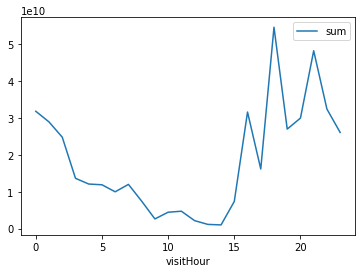

In [15]:
df_train.groupby('visitHour')['totals.totalTransactionRevenue'].agg(['sum']).plot();

### 10. (1) Prepare totals.totalTransactionRevenue for model training. Create a new column log_totals.totalTransactionRevenue = log(1+totals.totalTransactionRevenue). Drop column totals.totalTransactionRevenue. What is the mean value of the log_totals.totalTransactionRevenue column? (hint, both numpy and Orange have log1p function). `0.207`


In [16]:
import numpy as np

In [17]:
np.log1p(df_train['totals.totalTransactionRevenue']).mean()

0.20700909346007737

### 11. (0.5) Train a Catboost regression model to predict log_totals.totalTransactionRevenue. What is your test score in terms of MAE? Do not forget to apply all necessary preprocessing to a test part of the data.


In [18]:
from catboost import CatBoostRegressor, Pool

In [19]:
df_test = pd.read_csv('ha2_test.csv')

In [20]:
def return_X_y(df):
    fill_rare(df)
    X = df.drop(['totals.totalTransactionRevenue'], axis=1)    
    y = df['totals.totalTransactionRevenue']
    
    return X, y

X_train, y_train = return_X_y(df_train)
X_test, y_test = return_X_y(df_test)

In [21]:
dataset_train = Pool(X_train, np.log1p(y_train), cat_columns)
dataset_test = Pool(X_test, np.log1p(y_test), cat_columns)

In [22]:
model = CatBoostRegressor()

model.fit(dataset_train, eval_set=dataset_test,
          verbose=100)

Learning rate set to 0.12127
0:	learn: 1.8642300	test: 1.9865012	best: 1.9865012 (0)	total: 129ms	remaining: 2m 8s
100:	learn: 1.5396229	test: 1.6676410	best: 1.6676410 (100)	total: 6.83s	remaining: 1m
200:	learn: 1.4905106	test: 1.6360546	best: 1.6360546 (200)	total: 13.7s	remaining: 54.3s
300:	learn: 1.4582867	test: 1.6161950	best: 1.6161950 (300)	total: 20.6s	remaining: 47.9s
400:	learn: 1.4268355	test: 1.5996346	best: 1.5996304 (399)	total: 27.3s	remaining: 40.8s
500:	learn: 1.4052834	test: 1.5901328	best: 1.5901328 (500)	total: 34s	remaining: 33.9s
600:	learn: 1.3853062	test: 1.5820846	best: 1.5820655 (599)	total: 40.8s	remaining: 27.1s
700:	learn: 1.3660402	test: 1.5750242	best: 1.5749799 (698)	total: 47.4s	remaining: 20.2s
800:	learn: 1.3480482	test: 1.5682939	best: 1.5682939 (800)	total: 54.2s	remaining: 13.5s
900:	learn: 1.3326292	test: 1.5622199	best: 1.5622139 (899)	total: 1m 1s	remaining: 6.72s
999:	learn: 1.3181101	test: 1.5563520	best: 1.5563520 (999)	total: 1m 7s	remaini

### 12. (0.5) Check feature importances of a Catboost model, what are the top4 most important features? (comma divided list of column names)

In [23]:
importance = pd.DataFrame()
importance['feature importances'] = model.feature_importances_
importance['names'] = model.feature_names_

In [24]:
importance.sort_values('feature importances', ascending=False).iloc[:4]

,feature importances,names
11,23.314336,totals.pageviews
10,13.830964,totals.hits
14,11.724523,totals.sessionQualityDim
12,8.724324,totals.timeOnSite
